## Card Classification with Convolutional Neural Networks

This model will predict the classes of individual cards on a table.
The output will be one of the classes: Colosseo, Big Ben, Brandenburg Gate, Duomo, Eiffel, Sagrada Familia, Saint Basil Cathedral or Statute of liberty.
The final model is integrated in FER_card_detection and FER_card_detection_labels.py modules.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import cv2 
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## 1.Dataset

The images were generated with generate_individual_cards.py. They were saved in the folder individual_cards_dataset. Each image was saved in its corresponding folder.
I.e., Colosseo images were saved in subfolder Colosseo and so on.
Here, the images are read from these folders, and a CSV file with two columns: Image and Class is created.
This is done only once, so I can have one csv file to work with whenever I need it.

In [2]:
classes = ["Big_Ben", "Bradenburg_Gate", "Colosseo", "Duomo", "Eiffel", "Sagrada_familia",
           "Saint_Basil_Cathedral","Statue_of_liberty"]

In [3]:
dataset_df = pd.DataFrame(columns=["Image", "Class"])

In [4]:
Images_string = []
Labels = []

In [5]:
dataset_path = "D:\\PycharmProjects\\Visual-perception-for-an-Interactive-Robot-playing-Card-Games\\Dataset generation scripts\\individual_cards_dataset\\"

for i in range( 0,len(classes)):
    folder_path = dataset_path + classes[i] + "\\"
    for image in glob.glob(folder_path + "*.jpeg"):
        opened_image = cv2.imread(image, cv2.IMREAD_UNCHANGED)
        opened_image = opened_image.reshape(10000,)
        image_as_string = " ".join(str(e) for e in opened_image)
        Images_string.append(image_as_string)
        Labels.append(i)

In [6]:
dataset_df["Image"] = Images_string
dataset_df["Class"] = Labels

Save the dataset on a csv file with two columns: Image and Class.

In [7]:
dataset_df.to_csv(r"D:\PycharmProjects\Visual-perception-for-an-Interactive-Robot-playing-Card-Games\Dataset generation scripts\individual_cards_dataset\individual_cards_dataset.csv", index=False)

In [5]:
dataset = open("D:\PycharmProjects\Visual-perception-for-an-Interactive-Robot-playing-Card-Games\Dataset generation scripts\individual_cards_dataset\individual_cards_dataset.csv", "r")
dataset.__next__()

'Image,Class\n'

In [6]:
(Images, Labels) = ([], [])
for row in dataset:
    image, label = row.strip().split(",")
    image = np.array(image.split(" "),dtype="float32")
    image = image.reshape((100,100))
    Images.append(image)
    Labels.append(int(label))

In [7]:
dataset.close()

Split the dataset into training, validation and test images.

In [8]:
trainFullImages, testImages, trainFullLabels, testLabels = train_test_split(Images, Labels, test_size=0.1, random_state=42)
trainImages, validationImages, trainLabels, validationLabels = train_test_split(trainFullImages, trainFullLabels, test_size=0.2, random_state=42)

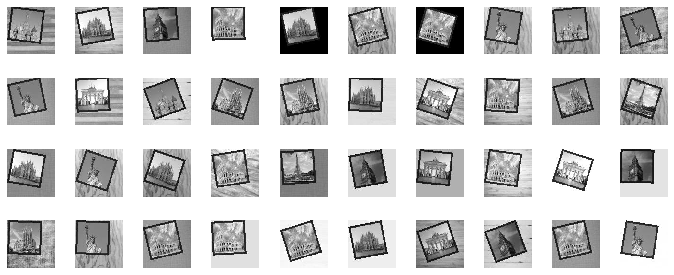

In [9]:
# let's see a few images of the dataset.
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(trainImages[index],cmap='gray', interpolation="nearest")
        plt.axis('off')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [10]:
trainImages = np.asarray(trainImages) 
validationImages = np.asarray(validationImages)
testImages = np.asarray(testImages) / 255.0

trainLabels = np.asarray(trainLabels)
validationLabels = np.asarray(validationLabels)
testLabels = np.asarray(testLabels)

In [11]:
trainImages = trainImages[..., np.newaxis]
validationImages = validationImages[..., np.newaxis]
testImages = testImages[..., np.newaxis]

In [12]:
print(f"Number of train images is {trainImages.shape[0]}, with dimensions ({trainImages.shape[1]}, {trainImages.shape[2]}, {trainImages.shape[3]}).")
print(f"Number of validation images is {validationImages.shape[0]}, with dimensions ({validationImages.shape[1]}, {validationImages.shape[2]}, {validationImages.shape[3]}).")
print(f"Number of test images is {testImages.shape[0]}, with dimensions ({testImages.shape[1]}, {testImages.shape[2]}, {testImages.shape[3]}).")

Number of train images is 48960, with dimensions (100, 100, 1).
Number of validation images is 12240, with dimensions (100, 100, 1).
Number of test images is 6800, with dimensions (100, 100, 1).


Let's do image data augmentation with ImageDataGenerator

In [13]:
train_image_generator = keras.preprocessing.image.ImageDataGenerator(
                                          rescale = 1/255.0,
                                          zoom_range=[0.5,1.5],
                                          width_shift_range=.2,
                                          height_shift_range=.2,
                                          shear_range=.2,
                                          brightness_range=[0.3, 1.5])

In [14]:
validation_image_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0)

In [15]:
train_image_generator.fit(trainImages)
validation_image_generator.fit(validationImages)

The dataset is ready to be fed to the model for training.

# 2. Model (Pruned)

In [16]:
epochs = 20
batch_size = 64
num_train_samples = trainImages.shape[0]
end_step = np.ceil(1.0 * num_train_samples / batch_size).astype(np.int32) * epochs
print('End step: ' + str(end_step))

End step: 15300


Below, the architecture of the CNN is created. Pruning is used to remove the connections that do not contribute to the accuracy, and make the model more leightweight.

In [17]:
from tensorflow_model_optimization.sparsity import keras as sparsity
from tensorflow import keras
from tensorflow.keras import layers
pruning_params = {
      'pruning_schedule': sparsity.PolynomialDecay(initial_sparsity=0.4,
                                                   final_sparsity=0.7,
                                                   begin_step=4000,
                                                   end_step=end_step,
                                                   frequency=500)
}

pruned_model = tf.keras.Sequential([
              sparsity.prune_low_magnitude(
                  layers.Conv2D(filters=64, input_shape=(100, 100, 1), kernel_size=(3,3), strides=(1,1), padding="same", kernel_initializer="he_normal"),
                  **pruning_params),
              layers.BatchNormalization(),
              layers.Activation(tf.nn.relu),
              layers.MaxPool2D(pool_size=2),
              sparsity.prune_low_magnitude(
                  layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding="same", kernel_initializer="he_normal"),
                  **pruning_params),
              layers.BatchNormalization(),
              layers.Activation(tf.nn.relu),
              layers.MaxPool2D(pool_size=2),
              layers.Dropout(0.5),
              
              sparsity.prune_low_magnitude(
              layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding="same", kernel_initializer="he_normal"),
                  **pruning_params),
              layers.BatchNormalization(),
              layers.Activation(tf.nn.relu),
              layers.MaxPool2D(pool_size=2),
              sparsity.prune_low_magnitude(
              layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding="same", kernel_initializer="he_normal"),
                  **pruning_params),
              layers.BatchNormalization(),
              layers.Activation(tf.nn.relu),
              layers.MaxPool2D(pool_size=2),
              layers.Dropout(0.5),
                  
              layers.Flatten(),
              sparsity.prune_low_magnitude(
              layers.Dense(units=128, activation="relu", kernel_initializer="he_normal"),
                  **pruning_params),
              layers.BatchNormalization(),
              layers.Dropout(0.5),
    
              sparsity.prune_low_magnitude(
              layers.Dense(units=128, activation="relu", kernel_initializer="he_normal"),
                  **pruning_params),
              layers.BatchNormalization(),
              layers.Dropout(0.5),
              
              sparsity.prune_low_magnitude(
              layers.Dense(units=8, activation="softmax", kernel_initializer="glorot_normal"),
                  **pruning_params)
              ])
pruned_model.summary()

D:\anaconda3\lib\site-packages\keras\engine\base_layer.py:2223: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_conv2d ( (None, 100, 100, 64)      1218      
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 100, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 100, 100, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 64)        0         
_________________________________________________________________
prune_low_magnitude_conv2d_1 (None, 50, 50, 64)        73794     
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 50, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 50, 50, 64)        0

In [18]:
opt = keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999,epsilon=1e-7)
pruned_model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

D:\anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor='val_accuracy', mode='max',patience=5)
mc = ModelCheckpoint('pruned_card_classification_model.h5', monitor='val_accuracy', mode='max', save_best_only=True)
s = sparsity.UpdatePruningStep()

In [20]:
history = pruned_model.fit_generator(train_image_generator.flow(trainImages, trainLabels, batch_size=batch_size),
                    steps_per_epoch=len(trainImages) // 64, epochs=epochs, validation_data=validation_image_generator.flow(validationImages, validationLabels),
                       callbacks=[es, mc, s])

D:\anaconda3\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
765/765 [==============================] - 119s 129ms/step - loss: 1.8985 - accuracy: 0.3648 - val_loss: 0.6571 - val_accuracy: 0.7752
Epoch 2/20
765/765 [==============================] - 95s 124ms/step - loss: 0.6392 - accuracy: 0.7788 - val_loss: 1.1991 - val_accuracy: 0.5876
Epoch 3/20
765/765 [==============================] - 96s 126ms/step - loss: 0.2578 - accuracy: 0.9170 - val_loss: 0.2441 - val_accuracy: 0.9074
Epoch 4/20
765/765 [==============================] - 96s 126ms/step - loss: 0.1453 - accuracy: 0.9544 - val_loss: 0.0659 - val_accuracy: 0.9825
Epoch 5/20
765/765 [==============================] - 97s 127ms/step - loss: 0.0968 - accuracy: 0.9689 - val_loss: 0.0306 - val_accuracy: 0.9889
Epoch 6/20
765/765 [==============================] - 98s 127ms/step - loss: 0.0794 - accuracy: 0.9761 - val_loss: 0.0254 - val_accuracy: 0.9914
Epoch 7/20
765/765 [==============================] - 97s 126ms/step - loss: 0.0530 - accuracy: 0.9844 - val_loss: 8.7331e-04 - v

In [27]:
score = pruned_model.evaluate(testImages, testLabels)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

213/213 [==============================] - 4s 19ms/step - loss: 0.0375 - accuracy: 0.9844
Test loss: 0.03747039660811424
Test accuracy: 0.9844117760658264


In [28]:
final_model = sparsity.strip_pruning(pruned_model)
final_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 64)      640       
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 100, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 100, 100, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 50, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 50, 50, 64)        0

In [29]:
tf.keras.models.save_model(final_model, 'card_model.h5')

In [30]:
new_model = tf.keras.models.load_model('card_model.h5')

In [31]:
opt = keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999,epsilon=1e-7)
new_model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [32]:
new_model.evaluate(testImages, testLabels)

213/213 [==============================] - 4s 18ms/step - loss: 0.0375 - accuracy: 0.9844


[0.03747039660811424, 0.9844117760658264]

## 3. Model Evaluation

### 3.1 Accuracy and Loss

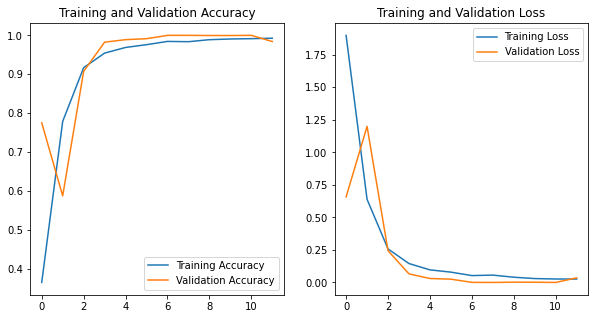

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(12)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 3.2 Confusion Matrix

In [ ]:
y_pred = new_model.predict(testImages)
y_pred_c =np.argmax(y_pred, axis=1)

In [ ]:
confusion_matrix = tf.math.confusion_matrix(testLabels, y_pred_c, num_classes=8)
confusion_matrix

<tf.Tensor: shape=(8, 8), dtype=int32, numpy=
array([[874,   0,   0,   0,   0,   0,   0,   0],
       [  0, 873,   0,   0,   0,   0,   0,   0],
       [  0,   0, 842,   0,   0,   0,   0,   0],
       [  0,   0,   0, 871,   0,   0,   0,   0],
       [  0,   0,   0,   0, 818,   0,   0,   0],
       [  0,   0,   0,   0,   0, 883,   0,   0],
       [  0,   0,   0,   0,   0, 106, 690,   0],
       [  0,   0,   0,   0,   0,   0,   0, 843]])>

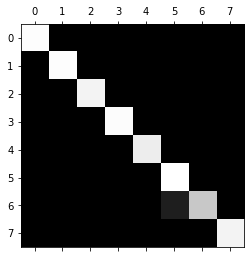

In [ ]:
def plot_confusion_matrix(matrix):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

plt.matshow(confusion_matrix, cmap=plt.cm.gray)
plt.show()